In [131]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import ShuffleSplit, cross_validate, LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor

In [3]:
cycling = pd.read_csv("../datasets/bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data.head()

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000


As a reminder, the problem we are trying to solve with this dataset is to use measurements from cheap sensors (GPS, heart-rate monitor, etc.) in order to predict a cyclist power. Power can indeed be recorded via a cycling power meter device, but this device is rather expensive.


Instead of using blindly machine learning, we will first introduce some flavor of classic mechanics: the Newton's second law.

$$P_{meca} = \left( \frac{1}{2} \rho.SC_x.V_a^2 + C_r.mg.\cos(\alpha) + ma \right)V_d$$

where $\rho$ is the air density in $\text{kg.m}^{−3}$, $S$ is frontal surface of the cyclist in $\text{m}^2$, $C_x$ is the drag coefficient, $V_a$ is the air speed in $\text{m.s}^{−1}$, $C_r$ is the rolling coefficient, $m$ is the mass of the rider and bicycle in $\text{kg}$, $g$ is the standard acceleration due to gravity which is equal to $9.81 \text{m.s}^{−2}$, $\alpha$ is the slope in radian, $V_d$ is the rider speed in $\text{m.s}^{−1}$, and $a$ is the rider acceleration in $\text{m.s}^{−2}$.

This equation might look a bit complex at first but we can explain with words what the different terms within the parenthesis are:

- the first term is the power that a cyclist is required to produce to fight wind
- the second term is the power that a cyclist is required to produce to fight the rolling resistance created by the tires on the floor
- the third term is the power that a cyclist is required to produce to go up a hill if the slope is positive. If the slope is negative the cyclist does not need to produce any power to go forward
- the fourth and last term is the power that a cyclist requires to change his speed (i.e. acceleration).

We can simplify the model above by using the data that we have at hand. It would look like the following.

$$P_{meca} = \beta_1V_d^3 + \beta_2V_d + \beta_3\sin(\alpha)V_d + \beta_4aV_d$$

This model is closer to what we saw previously: it is a linear model trained on a non-linear feature transformation. We will build, train and evaluate such a model as part of this exercise. Thus, you need to:

- create a new data matrix containing the cube of the speed, the speed, the speed multiplied by the sine of the angle of the slope, and the speed multiplied by the acceleration. To compute the angle of the slope, you need to take the arc tangent of the slope (`alpha = np.arctan(slope)`). In addition, we can limit ourself to positive acceleration only by clipping to 0 the negative acceleration values (they would correspond to some power created by the braking that we are not modeling here).
- using the new data matrix, create a linear predictive model based on a `sklearn.preprocessing.StandardScaler` and a `sklearn.linear_model.RidgeCV`;
- use a `sklearn.model_selection.ShuffleSplit` cross-validation strategy with only 4 splits (`n_splits=4`) to evaluate the generalization performance of the model. Use the mean absolute error (MAE) as a generalization performance metric. Also, pass the parameter `return_estimator=True` and `return_train_score=True` to answer the subsequent questions. Be aware that the `ShuffleSplit` strategy is a naive strategy and we will investigate the consequence of making this choice in the subsequent questions.

In [25]:
data["acceleration"]


2020-08-18 14:43:19    0.0880
2020-08-18 14:43:20    0.0842
2020-08-18 14:43:21    0.0234
2020-08-18 14:43:22    0.0016
2020-08-18 14:43:23    0.1144
                        ...  
2020-09-13 14:55:57    0.0234
2020-09-13 14:55:58    0.0258
2020-09-13 14:55:59   -0.1686
2020-09-13 14:56:00   -0.4284
2020-09-13 14:56:01   -0.3096
Name: acceleration, Length: 38254, dtype: float64

In [104]:
alpha = np.arctan(data["slope"])
data_linear_model = pd.DataFrame({
    "speed^3": data["speed"] ** 3,
    "speed": data["speed"],
    "sin(alpha)xspeed":np.sin(alpha)*data["speed"],
    "speedxacceleration": data["acceleration"].clip(lower=0)*data["speed"]})
data_linear_model.head()

,speed^3,speed,sin(alpha)xspeed,speedxacceleration
,,,,
2020-08-18 14:43:19,80.901828,4.325,-0.146402,0.380600
2020-08-18 14:43:20,81.520685,4.336,-0.145482,0.365091
2020-08-18 14:43:21,85.707790,4.409,-0.146398,0.103171
2020-08-18 14:43:22,87.824421,4.445,-0.146198,0.007112
2020-08-18 14:43:23,87.587538,4.441,0.000000,0.508050


### **Question 1**
What is the mean value of the column containing the information of $\sin(\alpha)V_d$?



In [105]:
data_linear_model["sin(alpha)xspeed"].mean()

-0.002709709612566326

In [106]:
preprocessor = StandardScaler()
linear_model = RidgeCV()
cv = ShuffleSplit(n_splits=4)

model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", linear_model),
])

cv_results = cross_validate(model, data_linear_model, target, cv=cv, scoring=["r2", "neg_mean_absolute_error"], return_estimator=True, return_train_score=True)

### **Question 2**
On average, the Mean Absolute Error on the test sets obtained through cross-validation is closest to:

In [107]:
-cv_results["test_neg_mean_absolute_error"]

array([71.26385633, 74.92819228, 72.30049202, 72.14151375])

In [108]:
cv_results

{'fit_time': array([0.01000857, 0.01001048, 0.00700617, 0.00900817]),
 'score_time': array([0.00100112, 0.00099969, 0.00200224, 0.00100088]),
 'estimator': [Pipeline(steps=[('preprocessor', StandardScaler()), ('regressor', RidgeCV())]),
  Pipeline(steps=[('preprocessor', StandardScaler()), ('regressor', RidgeCV())]),
  Pipeline(steps=[('preprocessor', StandardScaler()), ('regressor', RidgeCV())]),
  Pipeline(steps=[('preprocessor', StandardScaler()), ('regressor', RidgeCV())])],
 'test_r2': array([0.29241011, 0.29444967, 0.32295504, 0.29178804]),
 'train_r2': array([0.30912176, 0.30900557, 0.30571422, 0.30922047]),
 'test_neg_mean_absolute_error': array([-71.26385633, -74.92819228, -72.30049202, -72.14151375]),
 'train_neg_mean_absolute_error': array([-72.57277982, -72.17439786, -72.44373442, -72.48374179])}

### **Question 3**
Given the model $P_{meca}=\beta_1V^3_d+\beta_2V_d+\beta_3\sin(\alpha)V_d+\beta_4aV_d$ that you created, inspect the weights of the linear models fitted during cross-validation and select the correct statements:

In [109]:
for est in cv_results["estimator"]:
    print(est[-1].coef_)

[ 6.06233821 32.68618247 81.03437135 10.72369183]
[ 5.98039636 32.77739683 80.59444582 10.90224438]
[ 5.67345272 32.61933733 80.17763621 10.5735588 ]
[ 5.76620947 32.73354191 80.79863145 10.88918994]


### **Question 4**
Now, we will create a predictive model that uses all `data`, including available sensor measurements such as cadence (the speed at which a cyclist turns pedals measured in **rotation per minute**) and heart-rate (the number of **beat per minute** of the heart of the cyclist while exercising). Also, we will use a non-linear regressor, a `sklearn.ensemble.HistGradientBoostingRegressor`. Fix the number of maximum iterations to 1000 (`max_iter=1_000`) and activate the early stopping (`early_stopping=True`). Repeat the previous evaluation using this regressor.

In [110]:
preprocessor = StandardScaler()
linear_model = HistGradientBoostingRegressor(max_iter=1_000, early_stopping=True)
cv = ShuffleSplit(n_splits=4)

histgrad_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", linear_model),
])

histgrad_shuffle_cv_results = cross_validate(histgrad_model, data, target, cv=cv, scoring=["r2", "neg_mean_absolute_error"], return_estimator=True, return_train_score=True)

On average, the Mean Absolute Error on the test sets obtained through cross-validation is closest to:

In [111]:
-histgrad_shuffle_cv_results["test_neg_mean_absolute_error"]

array([45.30586892, 44.4842398 , 44.08165612, 44.00326853])

### **Question 5**
Comparing both the linear model and the histogram gradient boosting model and taking into consideration the train and test MAE obtained via cross-validation, select the correct statements:

In [112]:
preprocessor = StandardScaler()
linear_model = RidgeCV()
cv = ShuffleSplit(n_splits=4)

ridge_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", linear_model),
])

ridge_shuffle_cv_results = cross_validate(ridge_model, data, target, cv=cv, scoring=["r2", "neg_mean_absolute_error"], return_estimator=True, return_train_score=True)

In [113]:
pd.DataFrame({
    "ridge_test_MAE": -ridge_shuffle_cv_results["test_neg_mean_absolute_error"],
    "histgrad_test_MAE": -histgrad_shuffle_cv_results["test_neg_mean_absolute_error"],
    "ridge_train_MAE": -ridge_shuffle_cv_results["train_neg_mean_absolute_error"],
    "histgrad_train_MAE": -histgrad_shuffle_cv_results["train_neg_mean_absolute_error"]})

,ridge_test_MAE,histgrad_test_MAE,ridge_train_MAE,histgrad_train_MAE
0,65.176176,45.305869,64.721605,41.687313
1,64.990878,44.484240,64.756530,40.861913
2,64.087090,44.081656,64.854717,41.065422
3,63.344260,44.003269,64.915379,41.222298


### **Question 6**
In the previous cross-validation, we made the choice of using a `ShuffleSplit` cross-validation strategy. It means that randomly selected samples were selected as testing set ignoring any time dependency between the lines of the dataframe.

We would like to have a cross-validation strategy that takes into account the groups defined by each individual date. Each group corresponds to a bike ride.

How many bike rides are stored in the dataframe `data`?

In [114]:
pd.DataFrame(data.index.date).value_counts()

2020-08-26    10324
2020-08-18    10222
2020-08-20    10055
2020-09-13     7653
dtype: int64

### **Question 7**
We would like to have a cross-validation strategy that evaluates the capacity of our model to predict on a completely new bike ride: the samples in the validation set should only come from rides not present in the training set. Therefore, we can use a `LeaveOneGroupOut` strategy: at each iteration of the cross-validation, we will keep a bike ride for the evaluation and use all other bike rides to train our model.

Thus, you concretely need to:

- create a variable called `group` that is a 1D numpy array containing the index of each ride present in the dataframe. Therefore, the length of `group` will be equal to the number of samples in `data`. If we had 2 bike rides, we would expect the indices 0 and 1 in group to differentiate the bike ride. You can use `pd.factorize` to encode any Python types into integer indices.
- create a cross-validation object named `cv` using the `sklearn.model_selection.LeaveOneGroupOut` strategy.
- evaluate both the linear and histogram gradient boosting models with this strategy.

Using the previous evaluations (with the `LeaveOneGroupOut` strategy) and looking at the train and test errors for both models, select the correct statements:

In [115]:
cv = LeaveOneGroupOut()

groups = pd.factorize(data.index.date)[0]

ridge_model = Pipeline([
    ("preprocessor", StandardScaler()),
    ("regressor", RidgeCV()),
])

ridge_cv_results = cross_validate(ridge_model, data, target, groups=groups, cv=cv, scoring=["r2", "neg_mean_absolute_error"], return_estimator=True, return_train_score=True)

histgrad_model = Pipeline([
    ("preprocessor", StandardScaler()),
    ("regressor", HistGradientBoostingRegressor(max_iter=1_000, early_stopping=True)),
])

histgrad_cv_results = cross_validate(histgrad_model, data, target, groups=groups, cv=cv, scoring=["r2", "neg_mean_absolute_error"], return_estimator=True, return_train_score=True)

In [116]:
pd.DataFrame({
    "ridge_test_MAE": -ridge_cv_results["test_neg_mean_absolute_error"],
    "histgrad_test_MAE": -histgrad_cv_results["test_neg_mean_absolute_error"],
    "ridge_train_MAE": -ridge_cv_results["train_neg_mean_absolute_error"],
    "histgrad_train_MAE": -histgrad_cv_results["train_neg_mean_absolute_error"]})

,ridge_test_MAE,histgrad_test_MAE,ridge_train_MAE,histgrad_train_MAE
0,63.615010,47.631140,65.187488,39.704584
1,64.557179,48.641539,65.221694,39.562899
2,71.816032,53.960396,61.560610,37.244555
3,59.064311,49.197641,66.382196,39.932039


### **Question 8**
In this case we cannot compare cross-validation scores fold-to-fold as the folds are not aligned (they are not generated by the exact same strategy). Instead, compare the mean of the cross-validation test errors in the evaluations of the **linear model** to select the correct statement.

In [117]:
error = -ridge_shuffle_cv_results["test_neg_mean_absolute_error"]
print(f"Test MAE Ridge with ShuffleSplit: {error.mean():.3f} ± {error.std():.3f} Watts")

Test MAE Ridge with ShuffleSplit: 64.400 ± 0.736 Watts


In [118]:
error = -ridge_cv_results["test_neg_mean_absolute_error"]
print(f"Test MAE Ridge with LeaveOneGroupOut: {error.mean():.3f} ± {error.std():.3f} Watts")

Test MAE Ridge with LeaveOneGroupOut: 64.763 ± 4.571 Watts


### **Question 9**
Compare the mean of the cross-validation test errors in the evaluations of the **gradient-boosting model** to select the correct statement.

In [119]:
error = -histgrad_shuffle_cv_results["test_neg_mean_absolute_error"]
print(f"Test MAE gradient-boosting with ShuffleSplit: {error.mean():.3f} ± {error.std():.3f} Watts")

Test MAE gradient-boosting with ShuffleSplit: 44.469 ± 0.517 Watts


In [120]:
error = -histgrad_cv_results["test_neg_mean_absolute_error"]
print(f"Test MAE gradient-boosting with LeaveOneGroupOut: {error.mean():.3f} ± {error.std():.3f} Watts")

Test MAE gradient-boosting with LeaveOneGroupOut: 49.858 ± 2.434 Watts


### **Question 10**
Compare more precisely the errors estimated through cross-validation and select the correct statement:

In [121]:
error = -ridge_shuffle_cv_results["train_neg_mean_absolute_error"]
print(f"Train MAE gradient-boosting with ShuffleSplit: {error.mean():.3f} ± {error.std():.3f} Watts")
error = -ridge_cv_results["train_neg_mean_absolute_error"]
print(f"Train MAE Ridge with LeaveOneGroupOut: {error.mean():.3f} ± {error.std():.3f} Watts")
error = -histgrad_shuffle_cv_results["train_neg_mean_absolute_error"]
print(f"Train MAE gradient-boosting with ShuffleSplit: {error.mean():.3f} ± {error.std():.3f} Watts")
error = -histgrad_cv_results["train_neg_mean_absolute_error"]
print(f"Train MAE gradient-boosting with LeaveOneGroupOut: {error.mean():.3f} ± {error.std():.3f} Watts")

Train MAE gradient-boosting with ShuffleSplit: 64.812 ± 0.077 Watts
Train MAE Ridge with LeaveOneGroupOut: 64.588 ± 1.813 Watts
Train MAE gradient-boosting with ShuffleSplit: 41.209 ± 0.304 Watts
Train MAE gradient-boosting with LeaveOneGroupOut: 39.111 ± 1.086 Watts


### **Question 11**
Now, we will go more into details by picking a single ride for the testing and analyse the predictions of the models for this test ride. To do so, we can reuse the `LeaveOneGroupOut` cross-validation object in the following manner:

In [122]:
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=groups))[0]

data_linear_model_train = data_linear_model.iloc[train_indices]
data_linear_model_test = data_linear_model.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

Now, fit both the linear model and the histogram gradient boosting regressor models on the training data and collect the predictions on the testing data. Make a scatter plot where on the x-axis, you will plot the measured powers (true target) and on the y-axis, you will plot the predicted powers (predicted target). Do two separated plots for each model.

In [132]:
ridge_model = Pipeline([
    ("preprocessor", StandardScaler()),
    ("regressor", RidgeCV()),
])

histgrad_model = Pipeline([
    ("preprocessor", StandardScaler()),
    ("regressor", HistGradientBoostingRegressor(max_iter=1_000, early_stopping=True)),
])

ridge_model.fit(data_train, target_train)
ridge_predict = ridge_model.predict(data_test)
ridge_predict_actual = pd.DataFrame({
    "True values (Watts)": target_test, "Predicted values (Watts)": ridge_predict})

ridge_model.fit(data_linear_model_train, target_train)
ridge_linear_predict = ridge_model.predict(data_linear_model_test)
ridge_linear_predict_actual = pd.DataFrame({
    "True values (Watts)": target_test, "Predicted values (Watts)": ridge_linear_predict})

histgrad_model.fit(data_train, target_train)
histgrad_predict = histgrad_model.predict(data_test)
histgrad_predict_actual = pd.DataFrame({
    "True values (Watts)": target_test, "Predicted values (Watts)": histgrad_predict})

histgrad_model.fit(data_linear_model_train, target_train)
histgrad_linear_predict = histgrad_model.predict(data_linear_model_test)
histgrad_linear_predict_actual = pd.DataFrame({
    "True values (Watts)": target_test, "Predicted values (Watts)": histgrad_linear_predict})

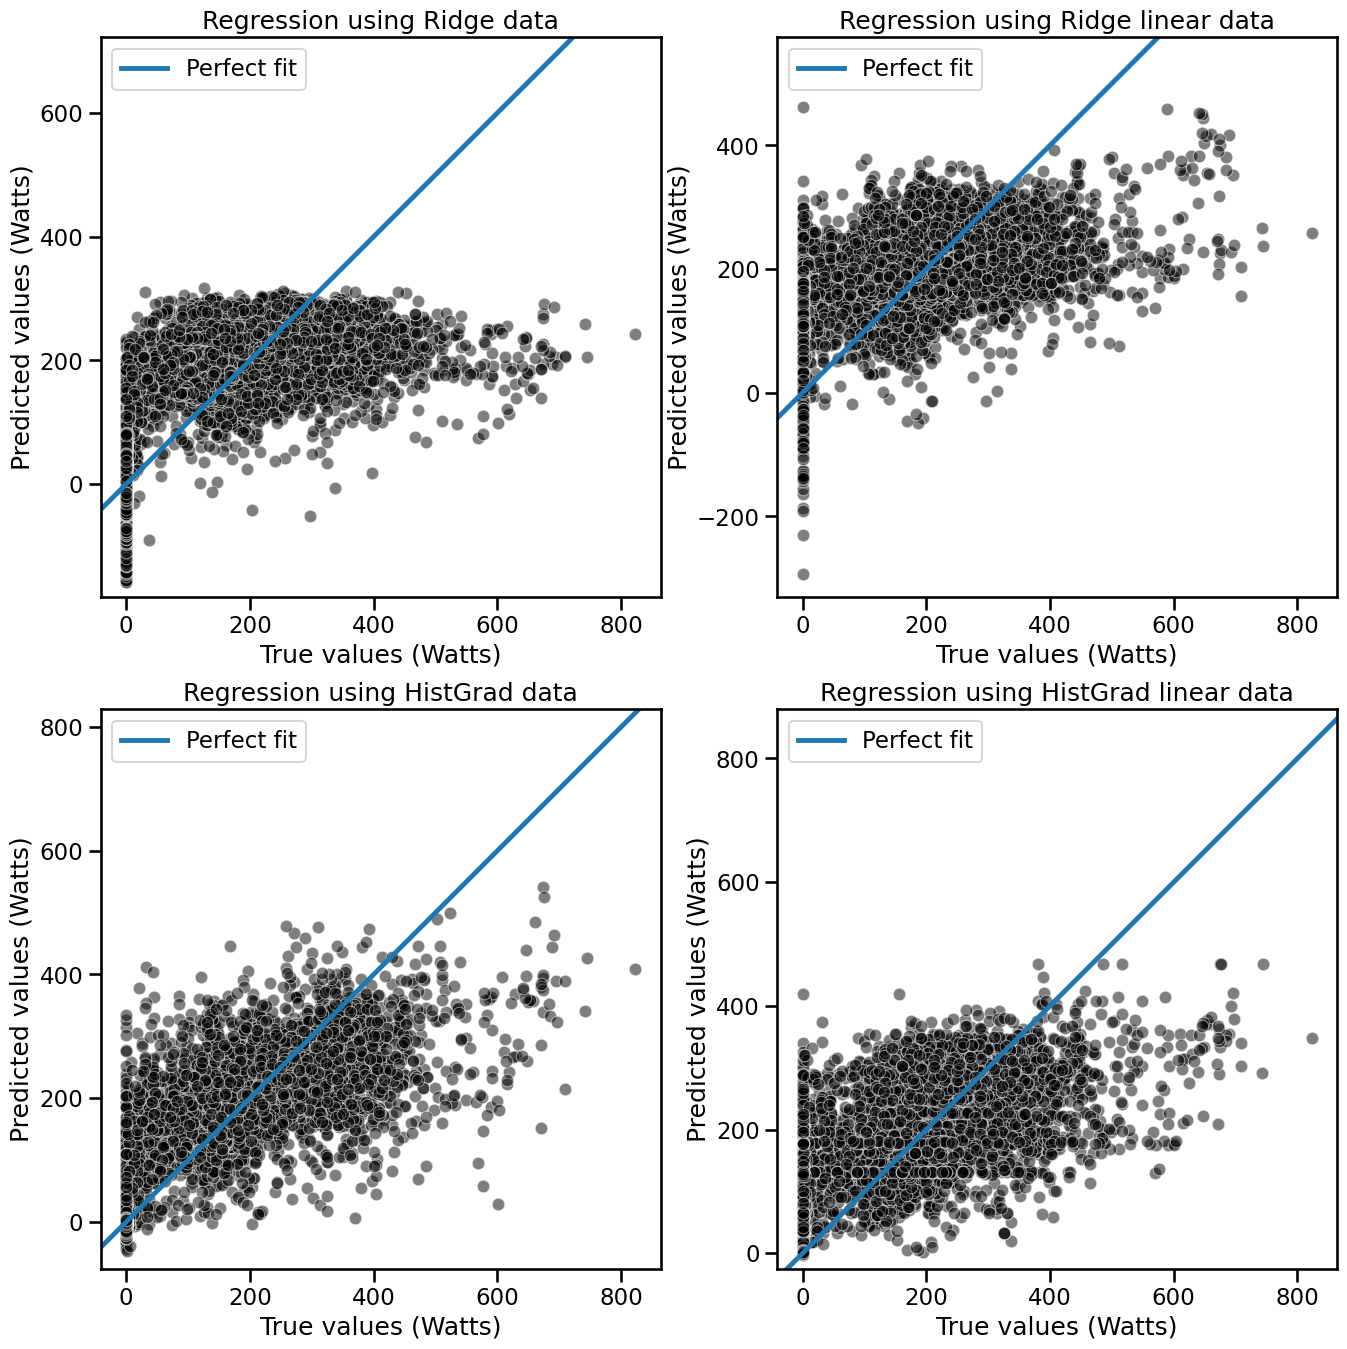

In [142]:

fig, axs = plt.subplots(2,2, figsize=(16,16))
axs = np.ravel(axs)

model_name = ["Ridge data", "Ridge linear data", "HistGrad data", "HistGrad linear data"]

for ax, data, name in zip(axs, [ridge_predict_actual, ridge_linear_predict_actual, histgrad_predict_actual, histgrad_linear_predict_actual], model_name):
    sns.scatterplot(data=data,
                    x="True values (Watts)", y="Predicted values (Watts)",
                    color="black", alpha=0.5, ax=ax)
    ax.axline((0, 0), slope=1, label="Perfect fit")
    ax.axis('square')
    ax.legend()
    _ = ax.set_title(f"Regression using {name}")

### **Question 12**
Now select a portion of the testing data using the following code:

In [144]:
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

It allows to select data from 5.00 pm until 5.05 pm. Used the previous fitted models (linear and gradient-boosting regressor) to predict on this portion of the test data. Draw on the same plot the true targets and the predictions of each model.

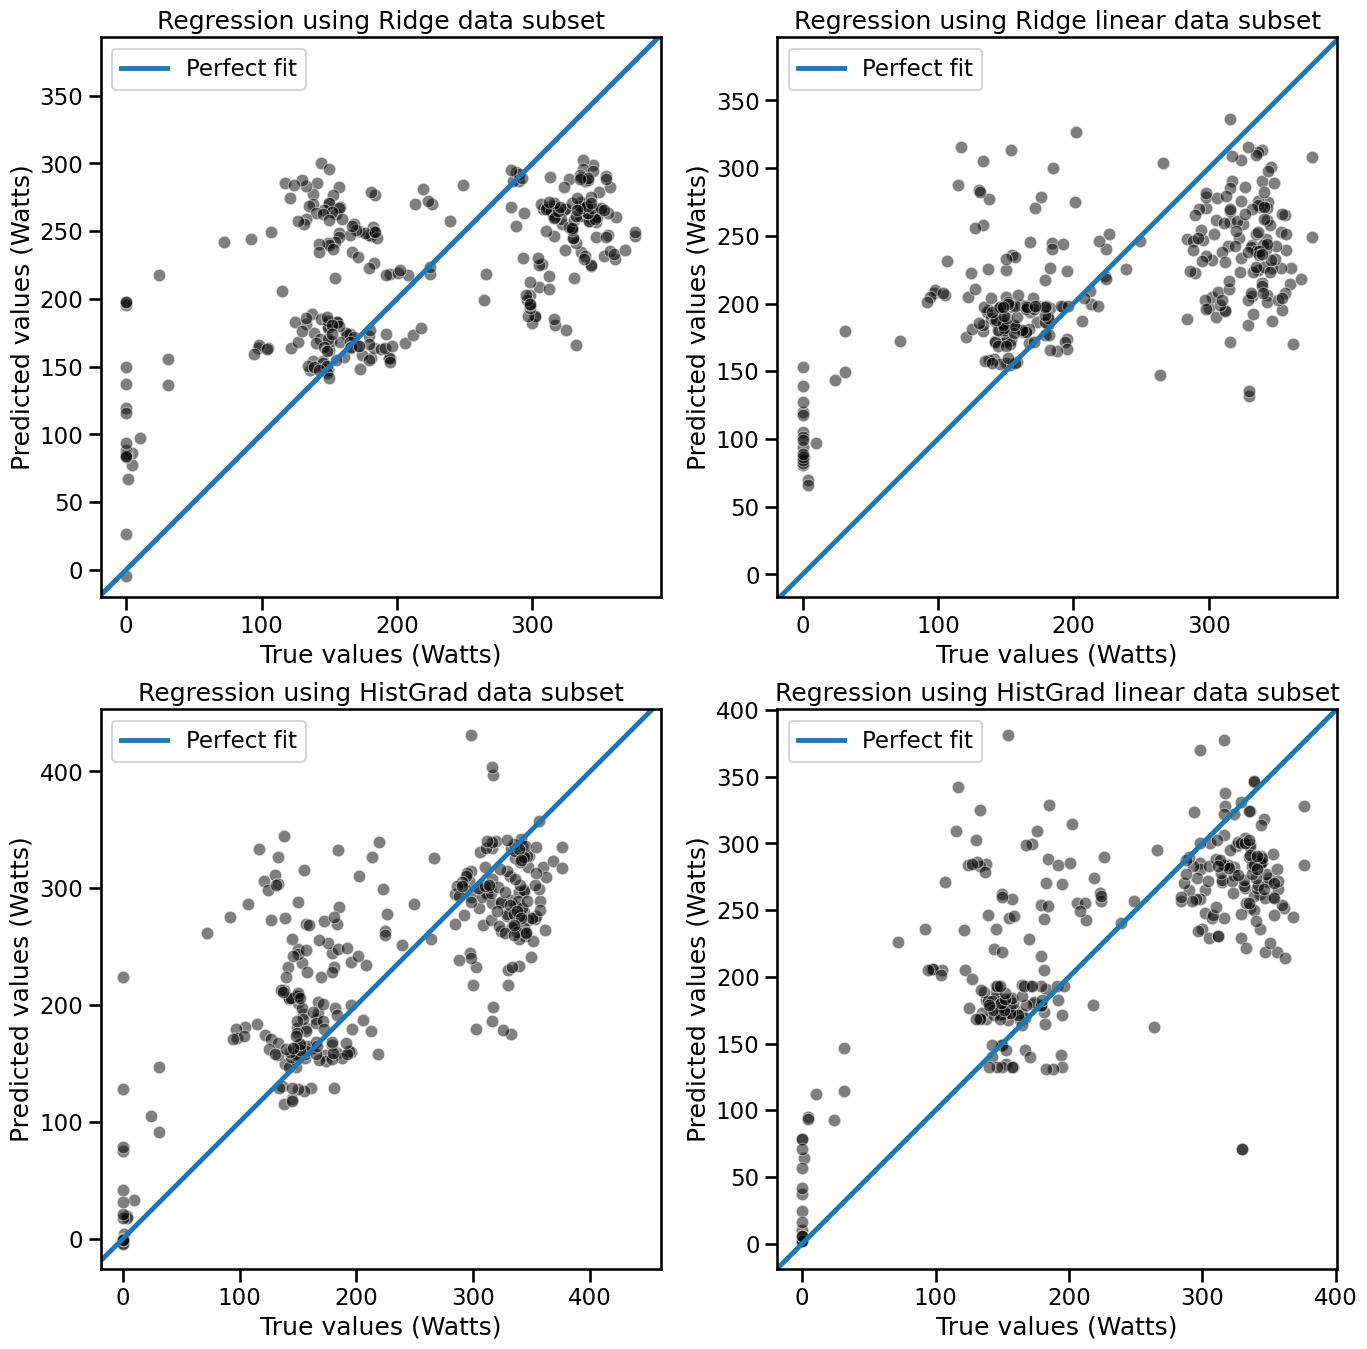

In [147]:
ridge_model.fit(data_train, target_train)
ridge_predict = ridge_model.predict(data_test_subset)
ridge_predict_actual = pd.DataFrame({
    "True values (Watts)": target_test_subset, "Predicted values (Watts)": ridge_predict})

ridge_model.fit(data_linear_model_train, target_train)
ridge_linear_predict = ridge_model.predict(data_test_linear_model_subset)
ridge_linear_predict_actual = pd.DataFrame({
    "True values (Watts)": target_test_subset, "Predicted values (Watts)": ridge_linear_predict})

histgrad_model.fit(data_train, target_train)
histgrad_predict = histgrad_model.predict(data_test_subset)
histgrad_predict_actual = pd.DataFrame({
    "True values (Watts)": target_test_subset, "Predicted values (Watts)": histgrad_predict})

histgrad_model.fit(data_linear_model_train, target_train)
histgrad_linear_predict = histgrad_model.predict(data_test_linear_model_subset)
histgrad_linear_predict_actual = pd.DataFrame({
    "True values (Watts)": target_test_subset, "Predicted values (Watts)": histgrad_linear_predict})

fig, axs = plt.subplots(2,2, figsize=(16,16))
axs = np.ravel(axs)

model_name = ["Ridge data subset", "Ridge linear data subset", "HistGrad data subset", "HistGrad linear data subset"]

for ax, data, name in zip(axs, [ridge_predict_actual, ridge_linear_predict_actual, histgrad_predict_actual, histgrad_linear_predict_actual], model_name):
    sns.scatterplot(data=data,
                    x="True values (Watts)", y="Predicted values (Watts)",
                    color="black", alpha=0.5, ax=ax)
    ax.axline((0, 0), slope=1, label="Perfect fit")
    ax.axis('square')
    ax.legend()
    _ = ax.set_title(f"Regression using {name}")